<a href="https://colab.research.google.com/github/zg104/DataScience/blob/master/Copy_of_Capstone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone

## [Data Preparation](#dp)
## [EDA](#eda)
## [Logistic Regression](#lr)
## [Model Evaluation](#ME)
## [Conclusion](#c)




## <span id="dp">Data Preparation</span>

### Load the data

In [3]:
## Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive/')

cancer_df = pd.read_csv('/content/drive/My Drive/Capstone/PAT_DATA_With_ZIPCODE.csv')
cancer_df.head()

zipcode = pd.read_csv('/content/drive/My Drive/Capstone/zipcode.csv')
zipcode.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


STATEFIPS STATE  zipcode  agi_stub  ...    N11902     A11902  N12000   A12000
0          1    AL        0         1  ...  698100.0  1796343.0  2860.0   4917.0
1          1    AL        0         2  ...  416180.0  1165352.0  4250.0   8894.0
2          1    AL        0         3  ...  197060.0   547812.0  5440.0  13482.0
3          1    AL        0         4  ...  118460.0   383588.0  3160.0  12369.0
4          1    AL        0         5  ...  130970.0   529001.0  8430.0  55564.0

[5 rows x 153 columns]

In [98]:
### import libraries ###

# basic
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV, cross_validate  #Perforing grid search
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 5

### Descriptive Analysis

In [4]:
# check the shape of the data
cancer_df.shape

(5953, 111)

In [5]:
cancer_df

_   visitid  siteid  ...  discharge           discharge2  ZIPCODE
0     2504  27742713       7  ...    Value 5     Medical Facility    20839
1     2433  26170864       7  ...    Value 1  Home/Self Care/Jail    20839
2     2637  21393532       7  ...    Value 1  Home/Self Care/Jail    20611
3     1017   6805230       1  ...    Value 1  Home/Self Care/Jail    21017
4     1223  10033541       2  ...    Value 1  Home/Self Care/Jail    21017
...    ...       ...     ...  ...        ...                  ...      ...
5948  3058  14762254       7  ...    Value 5                Rehab    25404
5949  3332  24354726       7  ...    Value 1  Home/Self Care/Jail    25403
5950  1490  16065164       2  ...    Value 4       Acute Hospital    17202
5951  4128  16985166       9  ...    Value 5     Medical Facility    60491
5952  5881  23193132      11  ...    Value 1  Home/Self Care/Jail    99999

[5953 rows x 111 columns]

In [6]:
# describe the data
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Columns: 111 entries, _ to ZIPCODE
dtypes: float64(45), int64(20), object(46)
memory usage: 5.0+ MB


### Data Quality Check

In [7]:
# data quality check
# null value check 
cancer_df.isna().sum()

_                0
visitid          0
siteid           0
patientnumber    0
admissiondate    0
                ..
race2            0
race3            0
discharge        0
discharge2       0
ZIPCODE          0
Length: 111, dtype: int64

In [ ]:
# # get rid of 4 patients that have no ICD-9
# cancer_df = cancer_df[(cancer_df['PatientID'] != 2736) &
#    (cancer_df['PatientID'] != 3640) &
#    (cancer_df['PatientID'] != 3726) &
#    (cancer_df['PatientID'] != 3851)]

In [12]:
fea_col = "gender age_admission race3 hospital group_type comorbidities complications admissiondate ZIPCODE readmission_30 readmission_90".split()
# Just select all needs variables in the dataset
fea_col
# Have a glance at the those column names

['gender',
 'age_admission',
 'race3',
 'hospital',
 'group_type',
 'comorbidities',
 'complications',
 'admissiondate',
 'ZIPCODE',
 'readmission_30',
 'readmission_90']

In [ ]:
# df = cancer_df[cancer_df["age_admission"]>=65][fea_col]
# df

In [ ]:
# df.admissiondate = df["admissiondate"].map(lambda x: x[-4:])#Only take the last four number as the year
# df.head()
# #Transform admissiondate to year of admission

In [13]:
df = cancer_df

In [14]:
# df = df[(df["admissiondate"] >= 2003) & (df["admissiondate"] <= 2012)]

In [15]:
# select feature columns we use
df = df[fea_col]

## Data Visualization

### Count Plot

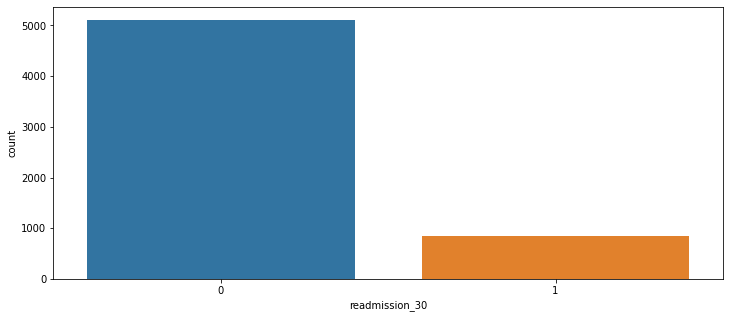

In [17]:
sns.countplot(cancer_df.readmission_30)
# Descriptive statistic summary for age for the patients

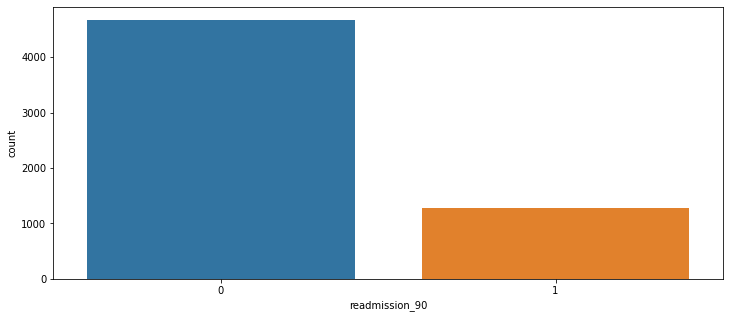

In [18]:
sns.countplot(cancer_df.readmission_90)

In [20]:
df.ZIPCODE.value_counts()

21222    177
21220    152
21221    139
20011    119
20019    101
        ... 
14901      1
14905      1
21052      1
2675       1
22539      1
Name: ZIPCODE, Length: 628, dtype: int64

<Figure size 864x360 with 0 Axes>

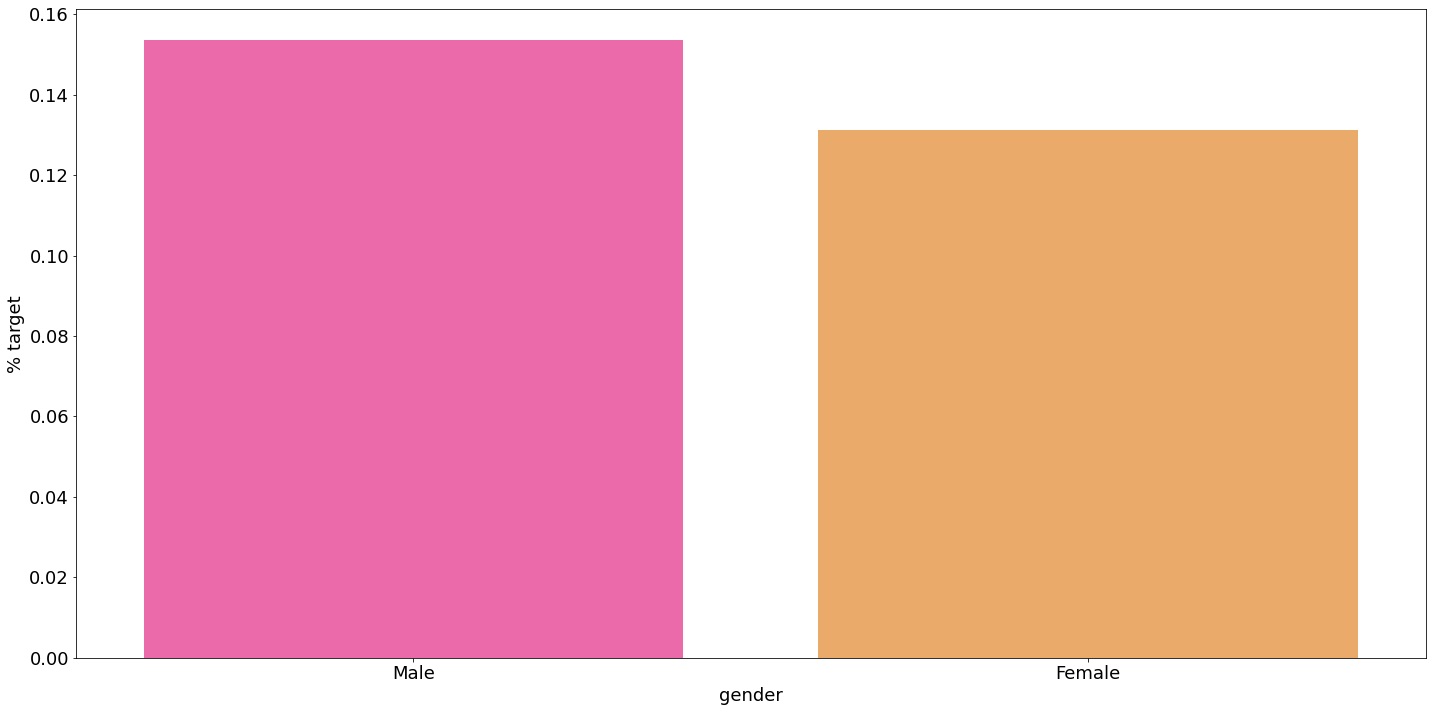

<Figure size 864x360 with 0 Axes>

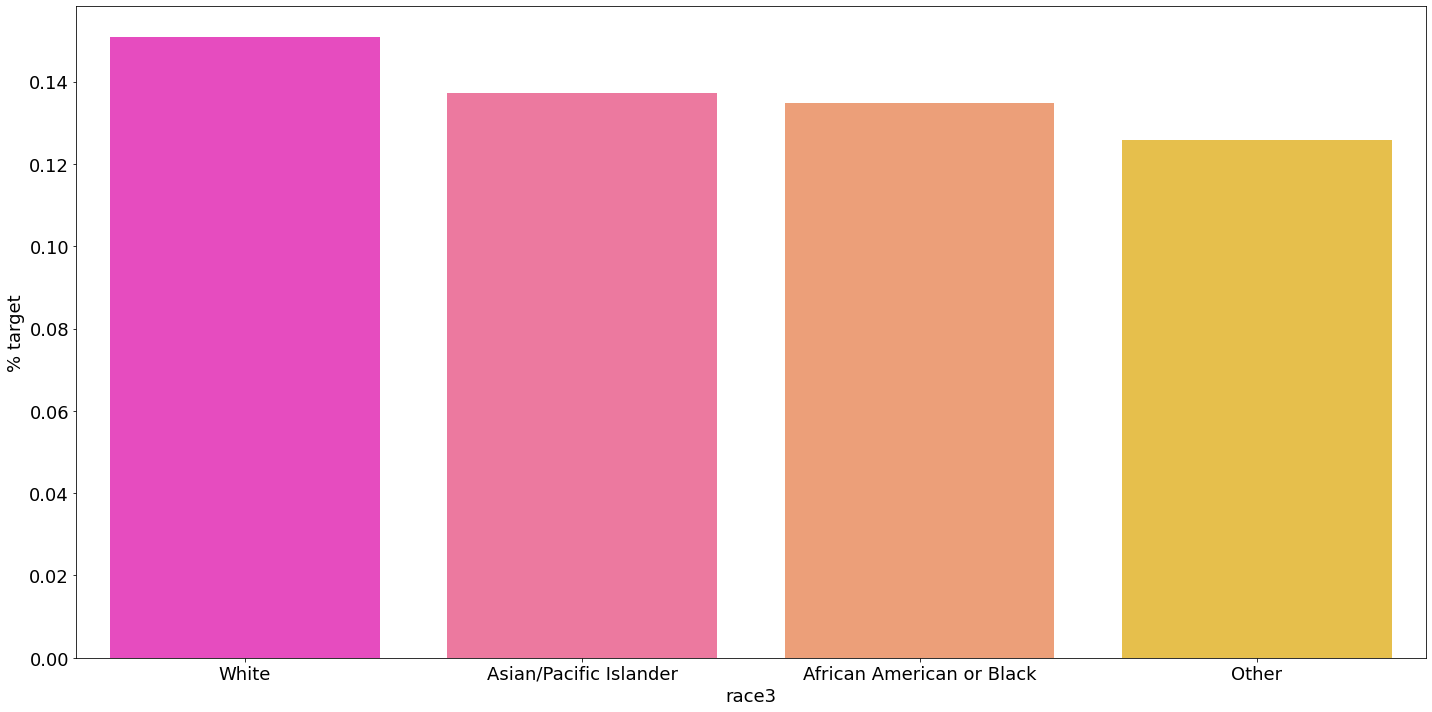

<Figure size 864x360 with 0 Axes>

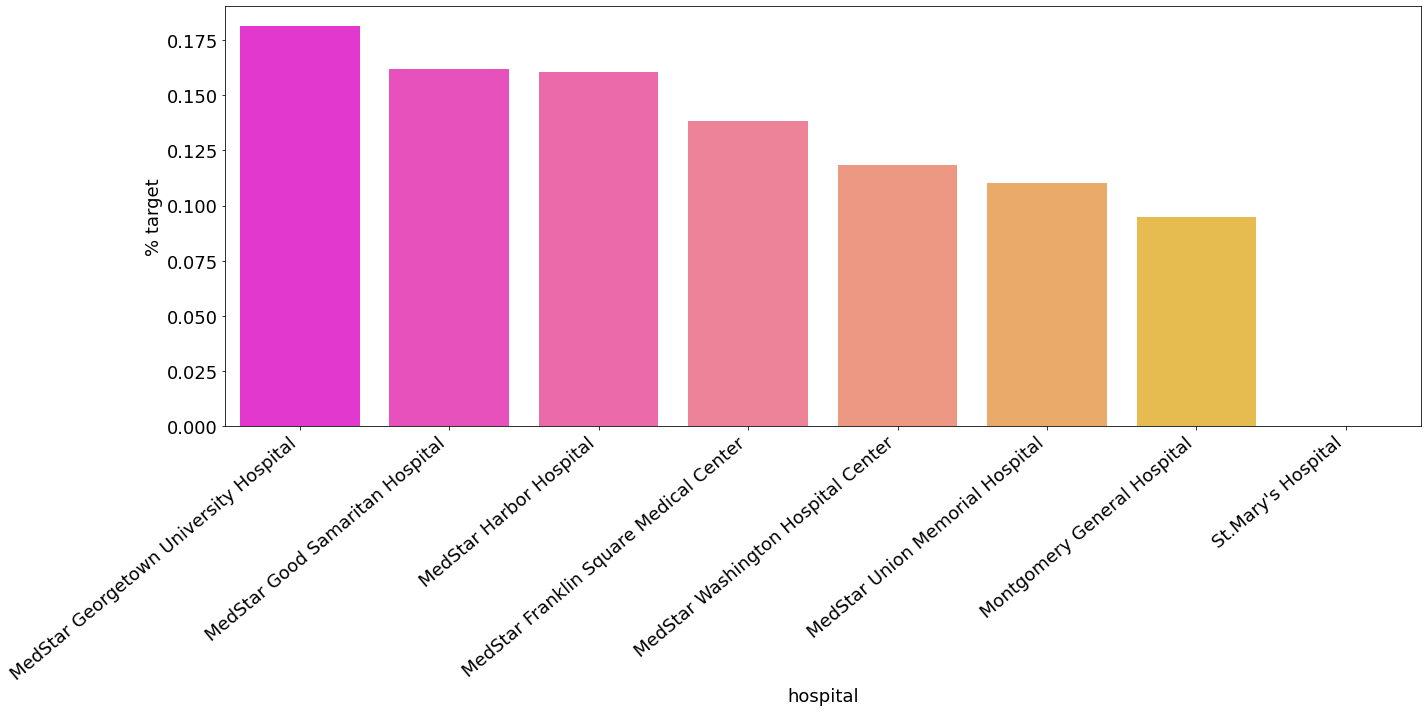

<Figure size 864x360 with 0 Axes>

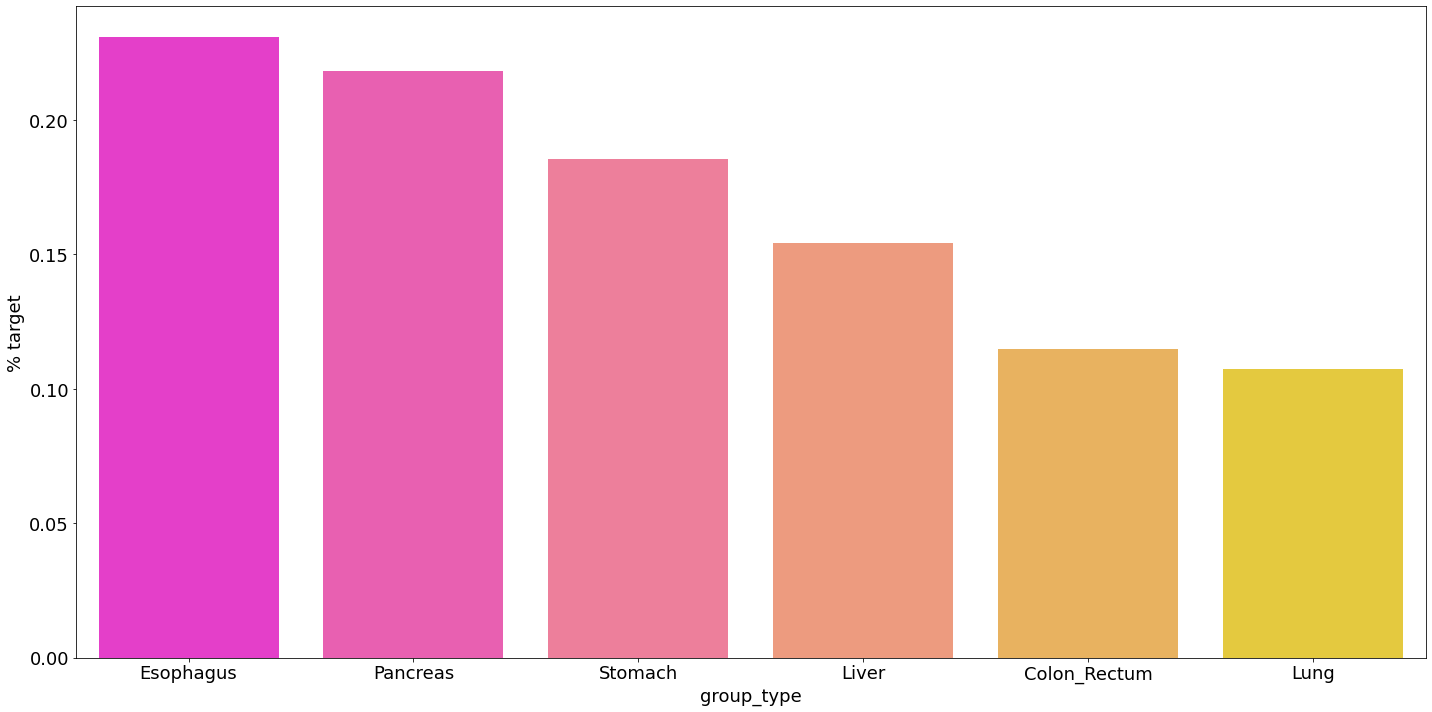

<Figure size 864x360 with 0 Axes>

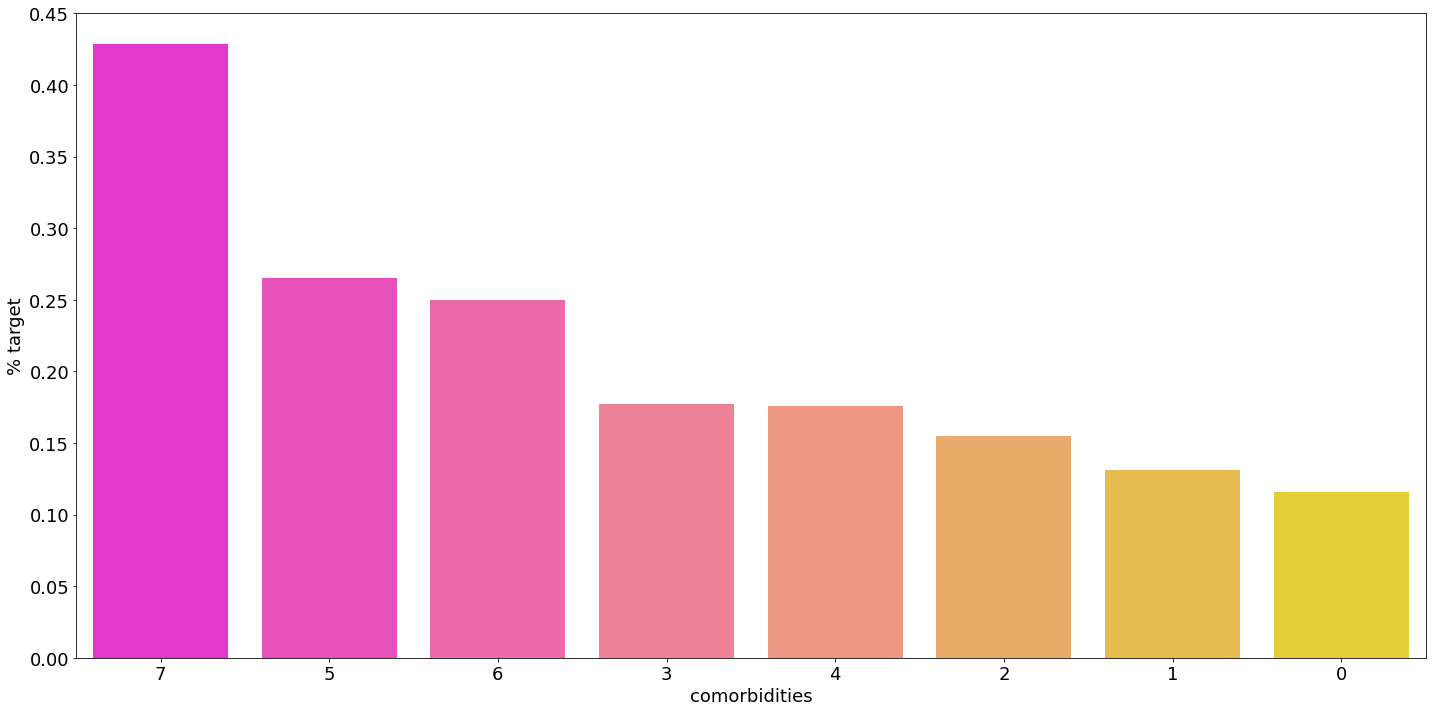

<Figure size 864x360 with 0 Axes>

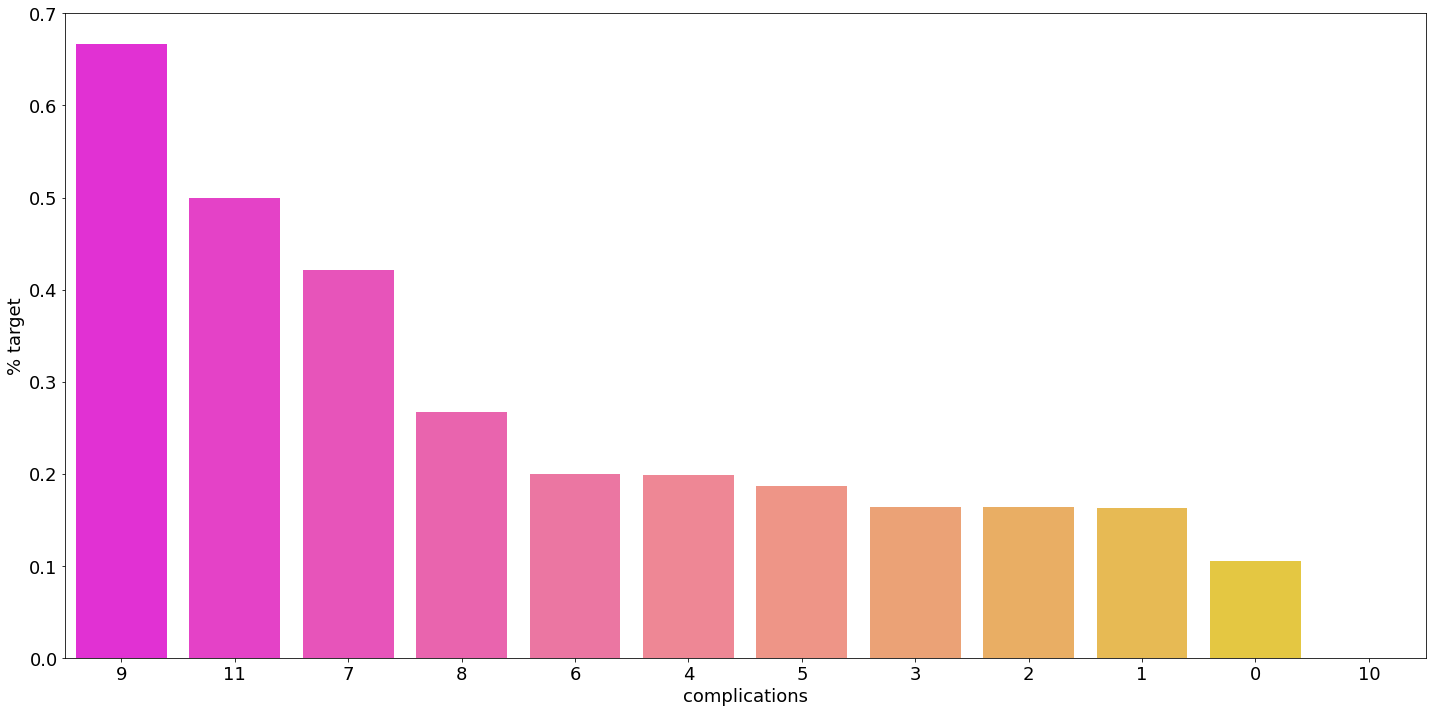

In [22]:
categorical_fea = ['gender', 'race3', 'hospital', 'group_type', 'comorbidities', 'complications']

for f in categorical_fea:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = df[[f, 'readmission_30']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='readmission_30', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='readmission_30', data=cat_perc, order=cat_perc[f], palette='spring')
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    if f == "hospital": ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show();

### Distribution Plot

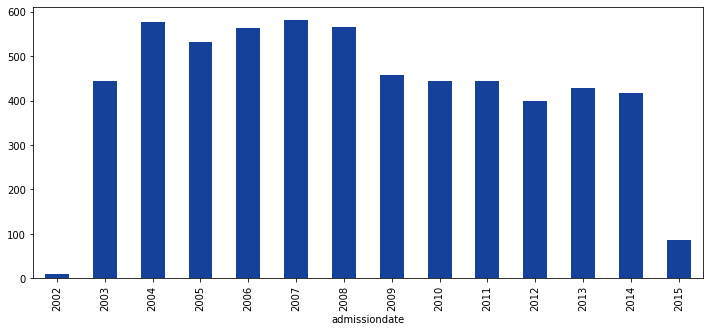

In [26]:
df['readmission_30'].groupby(df.admissiondate.astype("datetime64").dt.year).count().plot(kind="bar", color = '#16419B')

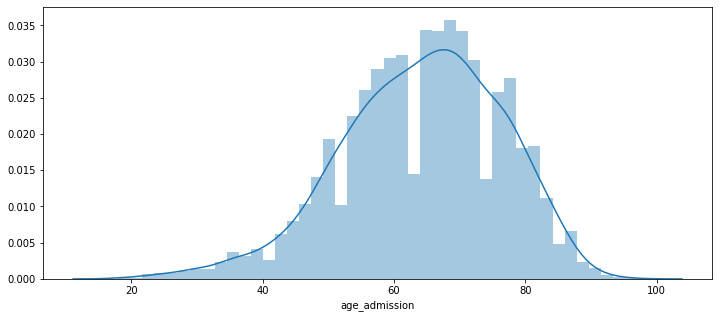

In [27]:
age = cancer_df["age_admission"]
sns.distplot(age)

### Correlation Plot

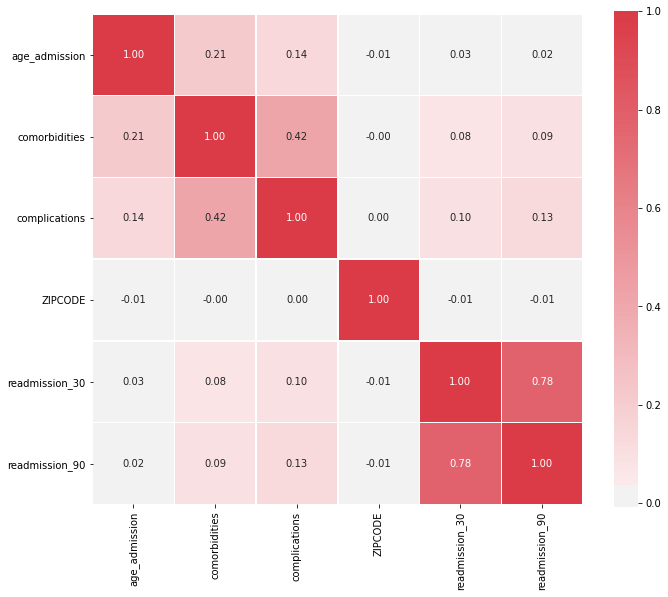

In [28]:
def corr_heatmap(v):
    correlations = df[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.tight_layout()
    plt.show();
corr_heatmap(fea_col)

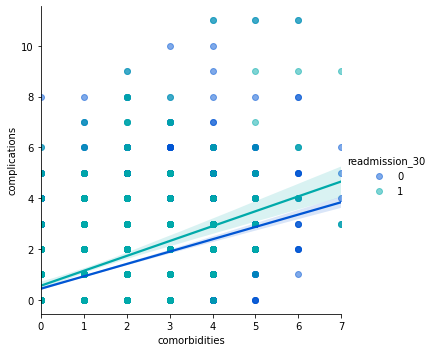

In [29]:
sns.lmplot(x='comorbidities', y='complications', data=df, hue='readmission_30', palette='winter', scatter_kws={'alpha':0.5})
plt.show()

White                        3271
African American or Black    1745
Other                         835
Asian/Pacific Islander        102
Name: race3, dtype: int64


<Figure size 7200x1440 with 0 Axes>

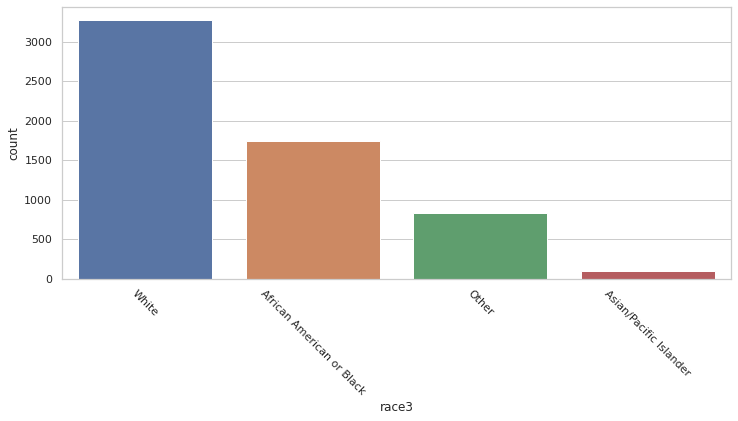

<Figure size 7200x1440 with 0 Axes>

In [30]:
sns.set(style="whitegrid")
ax = sns.countplot(x="race3", data=df)
print(df['race3'].value_counts())

plt.xticks(rotation = -45)
plt.figure(figsize=(100, 20))

### Feature Importance

In [ ]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(model, random_state = 0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

## Data Transformation

In [31]:
# df

### Under Sampling

In [32]:
from sklearn.utils import shuffle
desired_apriori=0.2

# Get the indices per target value
idx_0 = df[df['readmission_30'] == 0].index
idx_1 = df[df['readmission_30'] == 1].index

# Get original number of records per target value
nb_0 = len(df.loc[idx_0])
nb_1 = len(df.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
df_undersample = df.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.6635330983157071
Number of records with target=0 after undersampling: 3388


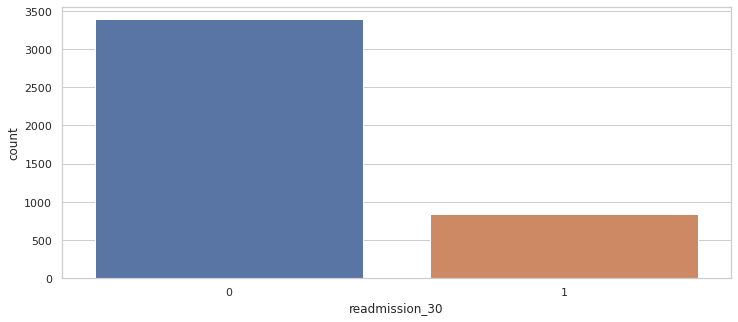

In [33]:
sns.countplot(df_undersample.readmission_30)

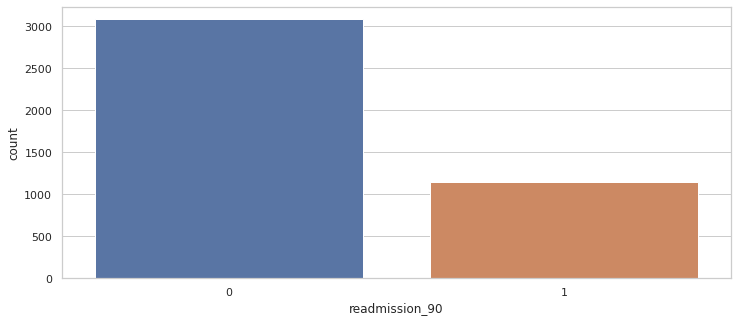

In [34]:
sns.countplot(df_undersample.readmission_90)

### Train Test Split

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(df_undersample.drop(["readmission_30", "readmission_90"], axis= 1), df_undersample['readmission_30'], df_undersample['readmission_90'], test_size=0.2, random_state=102)

## Categorical Data Encoding

### Target Encoding

In [36]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [37]:
col_target_encode = ['gender', 'age_admission', 'race3', 'hospital', 'group_type', 'comorbidities', 'complications', 'admissiondate', 'ZIPCODE']

for i in col_target_encode:
  X_train[i], X_test[i] = target_encode(X_train[i], 
                             X_test[i], 
                             target=y1_train, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [38]:
X_train.head()

gender  age_admission     race3  ...  complications  admissiondate   ZIPCODE
3343  0.187423       0.212648  0.188576  ...       0.248883       0.201220  0.199441
1462  0.183125       0.204065  0.188942  ...       0.156095       0.195473  0.201769
177   0.184055       0.201926  0.209138  ...       0.156612       0.198475  0.229520
3167  0.213763       0.183469  0.210828  ...       0.238175       0.199546  0.203117
2984  0.186920       0.211674  0.185344  ...       0.219753       0.198108  0.201634

[5 rows x 9 columns]

In [39]:
# combine train, test set 
df_for_te = pd.concat([X_train,X_test],axis=0)

y1 = pd.concat([y1_train,y1_test],axis=0)
y2 = pd.concat([y2_train,y2_test],axis=0)

### One Hot Encoding

In [61]:
df_for_oe = df_undersample

In [62]:
# partition by age group
def age_group(x):
  if (x >= 65) & (x <= 69):
    return 0
  elif (x >= 70) & (x <= 74):
    return 1
  elif (x >= 75) & (x <= 79):
    return 2
  else:
    return 3

df_for_oe.age_admission = df_for_oe.age_admission.apply(lambda x: age_group(x))

In [63]:
# So as comorbidities and complications
def c_group(x):
  if x == 0:
    return 0
  elif x == 1:
    return 1
  elif x == 2:
    return 2
  else:
    return 3


df_for_oe.comorbidities = df_for_oe.comorbidities.apply(lambda x: c_group(x))

df_for_oe.complications = df_for_oe.complications.apply(lambda x: c_group(x))


In [64]:
df_for_oe.head()

gender  age_admission  race3  ... ZIPCODE readmission_30  readmission_90
0  Female              0  White  ...   21014              0               0
1    Male              3  White  ...   20007              0               0
2  Female              3  Other  ...   20111              0               1
3  Female              3  White  ...   21093              0               0
4    Male              2  White  ...   21028              0               0

[5 rows x 11 columns]

In [65]:
df_for_oe.admissiondate = df_for_oe["admissiondate"].map(lambda x: x[-2:]) #Only take the last four number as the year
df_for_oe.head()

gender  age_admission  race3  ... ZIPCODE readmission_30  readmission_90
0  Female              0  White  ...   21014              0               0
1    Male              3  White  ...   20007              0               0
2  Female              3  Other  ...   20111              0               1
3  Female              3  White  ...   21093              0               0
4    Male              2  White  ...   21028              0               0

[5 rows x 11 columns]

In [66]:
for i in df_for_oe.columns:
  df_for_oe[i] = df_for_oe[i].apply(lambda x : str(x))

In [67]:
df_for_oe = pd.get_dummies(df_for_oe[fea_col[:-2]],drop_first=True)
df_for_oe.head()

gender_Male  age_admission_1  ...  ZIPCODE_96753  ZIPCODE_99999
0            0                0  ...              0              0
1            1                0  ...              0              0
2            0                0  ...              0              0
3            0                0  ...              0              0
4            1                0  ...              0              0

[5 rows x 584 columns]

In [68]:
y1_oe = df_undersample['readmission_30'].astype(int)
y2_oe = df_undersample['readmission_90'].astype(int)
X_train_oe, X_test_oe, y1_train_oe, y1_test_oe, y2_train_oe, y2_test_oe = train_test_split(df_for_oe, y1_oe, y2_oe, test_size=0.2, random_state=102)

### Label Encoding

In [69]:
df_for_le = df_undersample

In [70]:
encoder = LabelEncoder()
df_for_le = df_for_le[fea_col[:-2]].apply(encoder.fit_transform)

In [71]:
df_for_le.head()

gender  age_admission  race3  ...  complications  admissiondate  ZIPCODE
0       0              0      3  ...              0              1      238
1       1              3      3  ...              0              3       38
2       0              3      2  ...              1             10       63
3       0              3      3  ...              3              5      274
4       1              2      3  ...              0              1      244

[5 rows x 9 columns]

In [72]:
y1_le = df_undersample['readmission_30'].astype(int)
y2_le = df_undersample['readmission_90'].astype(int)
X_train_le, X_test_le, y1_train_le, y1_test_le, y2_train_le, y2_test_le = train_test_split(df_for_le, y1_le, y2_le, test_size=0.2, random_state=102)

## Chi Square Test

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical_features = df.columns[:10]
df_2 = df[categorical_features].apply(encoder.fit_transform)

In [ ]:
df_2.to_csv('labelencoder_df.csv')

In [ ]:
df.race3.value_counts()

White                        3269
African American or Black    1744
Other                         835
Asian/Pacific Islander        101
Name: race3, dtype: int64

In [ ]:
d1 = df[['race3','readmission_30']]

In [ ]:
a = d1[d1.readmission_30 == '0'].iloc[:,0].value_counts()/ sum(d1[d1.readmission_30 == '0'].iloc[:,0].value_counts())
print('target = 1','\n', round(a,2))

target = 1 
 Series([], Name: race3, dtype: float64)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
def trans(df, col, target):
  data = df[[col,target]]
  v1 = data[data[target] == '0'].iloc[:,0].value_counts()/ sum(data[data[target] == '0'].iloc[:,0].value_counts())
  print('target = 0')
  print(round(100*v1,1))
  print('分割～～～～～～～～～～～～～～～～')
  v2 = data[data[target] == '1'].iloc[:,0].value_counts()/ sum(data[data[target] == '1'].iloc[:,0].value_counts())
  print('target = 1')
  print(round(100*v2,1))
  print("结束==============================")

In [ ]:
# col_to_use = ['gender', 'age_admission', 'race3', 'hospital', 'group_type', 'comorbidities',
#        'complications', 'admissiondate']  # primary_insurance_plan

# for col in col_to_use:
#   trans(df,col,'readmission_30')
#   print("前面是30<<<<<<<<<<#####>>>>>>>>>>后面是90")
#   trans(df,col,'readmission_90')

In [ ]:
df_2 = df[categorical_features].apply(encoder.fit_transform)

In [ ]:
df_2

gender  age_admission  ...  readmission_30  readmission_90
0          1             39  ...               0               0
1          1             44  ...               0               0
2          0             52  ...               0               0
3          0             46  ...               0               1
4          0             72  ...               0               0
...      ...            ...  ...             ...             ...
5948       0             61  ...               0               0
5949       0             45  ...               0               0
5950       1             38  ...               0               0
5951       1             31  ...               0               0
5952       1             42  ...               0               0

[5949 rows x 10 columns]

## Normalization 

In [ ]:
# def norm(col):
#   return col / np.sqrt(np.sum([x**2 for x in col]))

# for i in X_train.columns:
#   X_train[i] = norm(X_train[i])
#   X_test[i] = norm(X_test[i])

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# X_train_scale = scaler.fit_transform(X_train)
# X_test_scale = scaler.transform(X_test)

## Data Modeling

### Logistic Regression

In [84]:
# target encoding
clf_1 = LogisticRegression(max_iter = 1000, random_state=0).fit(X_train, y1_train)
pred_1 = clf_1.predict(X_test)
prob_1 = clf_1.predict_proba(X_test)


# one hot encoding
clf_2 = LogisticRegression(max_iter = 1000, random_state=0).fit(X_train_oe, y1_train_oe)
pred_2 = clf_2.predict(X_test_oe)
prob_2 = clf_2.predict_proba(X_test_oe)

# label encoding
clf_3 = LogisticRegression(max_iter = 1000, random_state=0).fit(X_train_le, y1_train_le)
pred_3 = clf_3.predict(X_test_le)
prob_3 = clf_3.predict_proba(X_test_le)

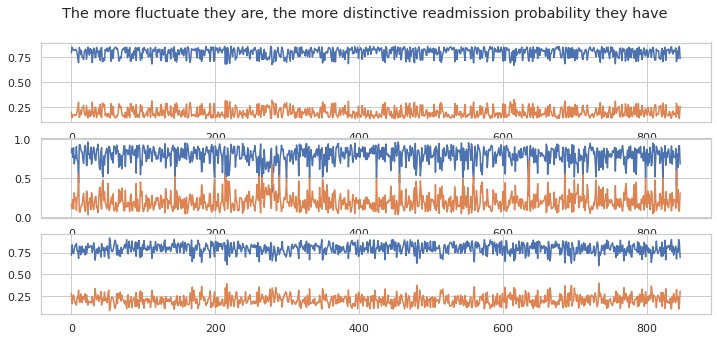

In [85]:
fig, axs = plt.subplots(3)
fig.suptitle('The more fluctuate they are, the more distinctive readmission probability they have')
axs[0].plot(pd.DataFrame(prob_1))
axs[1].plot(pd.DataFrame(prob_2))
axs[2].plot(pd.DataFrame(prob_3))

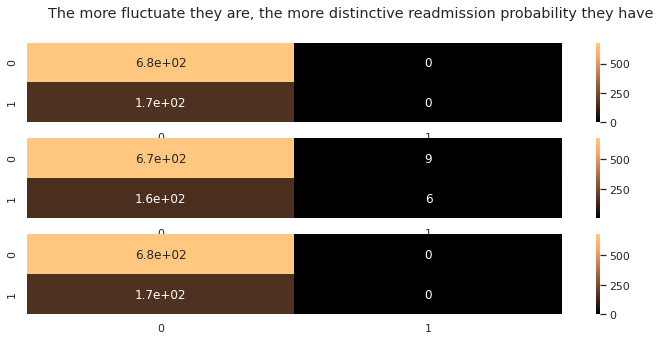

In [87]:
fig, axs = plt.subplots(3)
fig.suptitle('The more fluctuate they are, the more distinctive readmission probability they have')

sns.heatmap(pd.DataFrame(confusion_matrix(y1_test, pred_1)), annot=True, ax=axs[0], cmap='copper')
sns.heatmap(pd.DataFrame(confusion_matrix(y1_test_oe, pred_2)), annot=True, ax=axs[1], cmap='copper')
sns.heatmap(pd.DataFrame(confusion_matrix(y1_test_le, pred_3)), annot=True, ax=axs[2], cmap='copper')

### XGBoost

In [88]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, readmission = 'readmission_30'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[readmission].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[readmission],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[readmission].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[readmission], dtrain_predprob))
    print(confusion_matrix(dtrain_predictions,dtrain[readmission].values))
    print(classification_report(dtrain_predictions,dtrain[readmission].values))

    pd.DataFrame(alg.predict_proba(dtrain[predictors])).plot()
    plt.show()

    sns.heatmap(pd.DataFrame(confusion_matrix(dtrain_predictions,dtrain[readmission].values)), annot=True, cmap='copper', fmt="d")
    plt.show()


    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.999996
[[3388   61]
 [   0  786]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3449
           1       0.93      1.00      0.96       786

    accuracy                           0.99      4235
   macro avg       0.96      0.99      0.98      4235
weighted avg       0.99      0.99      0.99      4235



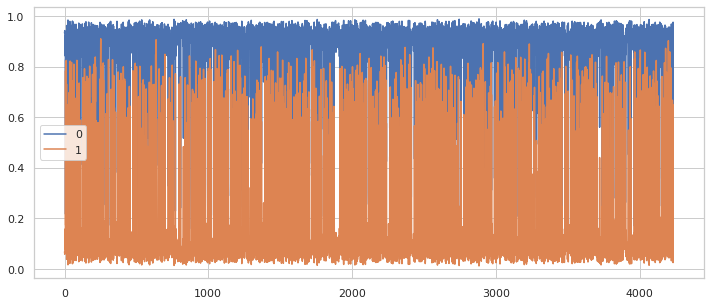

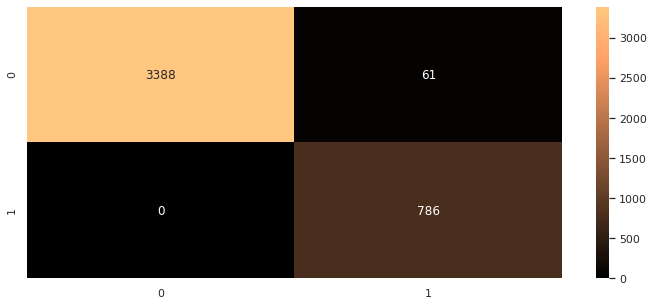

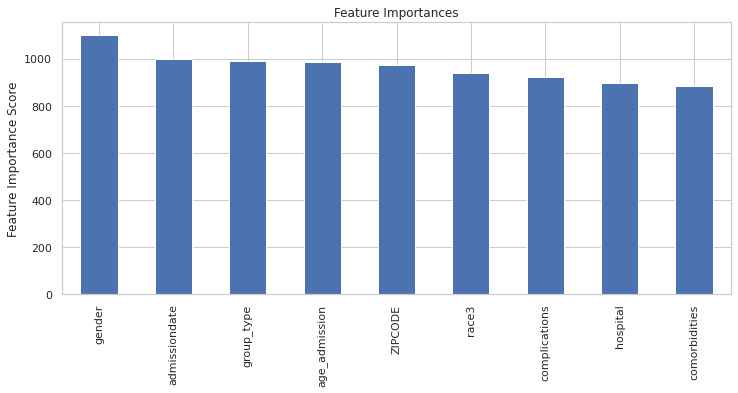

In [89]:
# target encoding
df_for_te['readmission_30'] = y1.astype(int)
# X_train['readmission_90'] = y2_train.astype(int)
predictors = [x for x in df_for_te.columns[:-1]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=60,
 max_depth=12,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=2)
modelfit(xgb1, df_for_te, predictors, readmission = "readmission_30")


Model Report
Accuracy : 0.863
AUC Score (Train): 0.943279
[[3382  574]
 [   6  273]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3956
           1       0.32      0.98      0.48       279

    accuracy                           0.86      4235
   macro avg       0.66      0.92      0.70      4235
weighted avg       0.95      0.86      0.89      4235



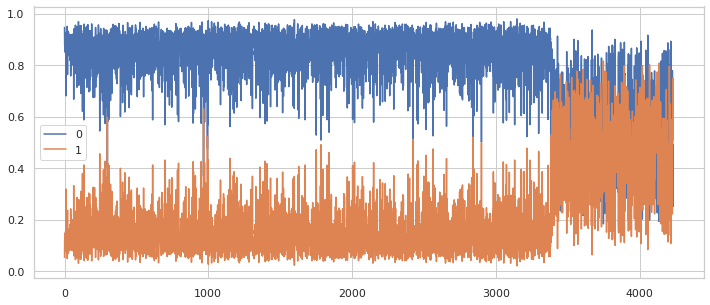

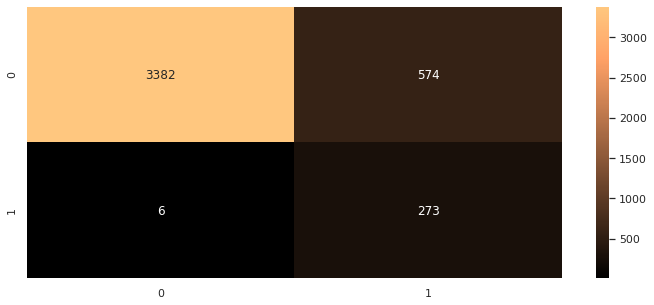

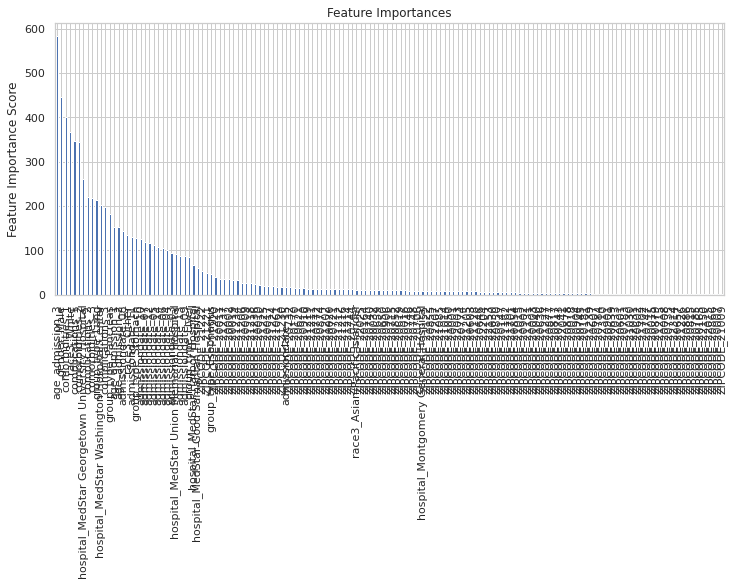

In [90]:
# one hot encoding
df_for_oe['readmission_30'] = y1_oe.astype(int)
# X_train['readmission_90'] = y2_train.astype(int)
predictors = [x for x in df_for_oe.columns[:-1]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=20,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=1)
modelfit(xgb1, df_for_oe, predictors, readmission = "readmission_30")


Model Report
Accuracy : 0.9341
AUC Score (Train): 0.997296
[[3386  277]
 [   2  570]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3663
           1       0.67      1.00      0.80       572

    accuracy                           0.93      4235
   macro avg       0.84      0.96      0.88      4235
weighted avg       0.96      0.93      0.94      4235



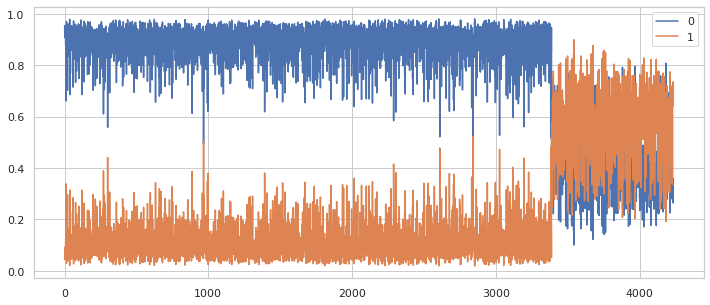

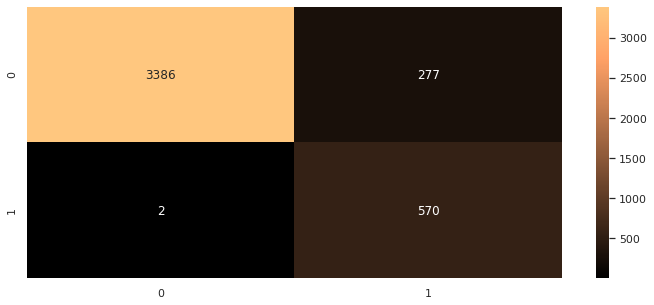

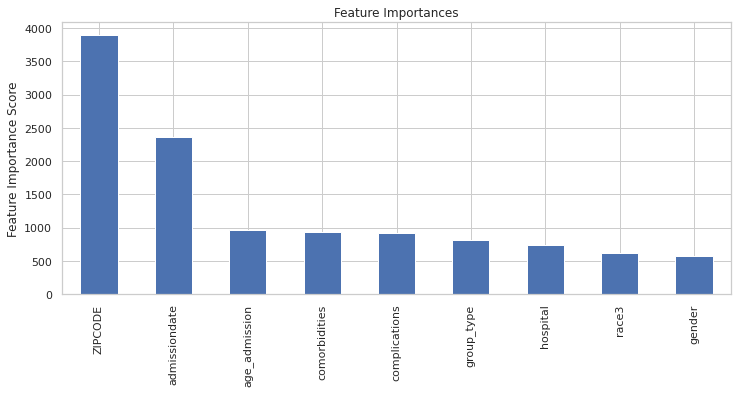

In [91]:
# label encoding
def norm(col):
  return col / np.sqrt(np.sum([x**2 for x in col]))

for i in df_for_le.columns[1:]:
  df_for_le[i] = norm(df_for_le[i])

df_for_le['readmission_30'] = y1_le.astype(int)
# X_train['readmission_90'] = y2_train.astype(int)
predictors = [x for x in df_for_le.columns[:-1]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=15,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=123)
modelfit(xgb1, df_for_le, predictors, readmission = "readmission_30")

### Random Forest

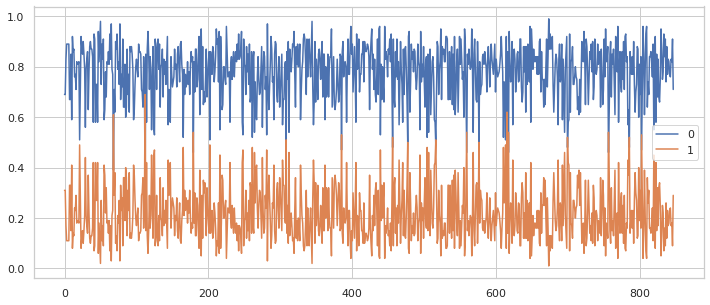

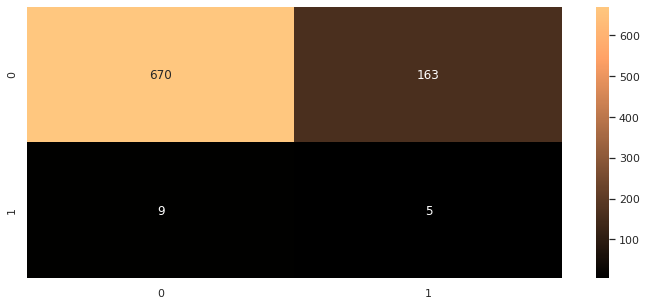

0.508253559155621


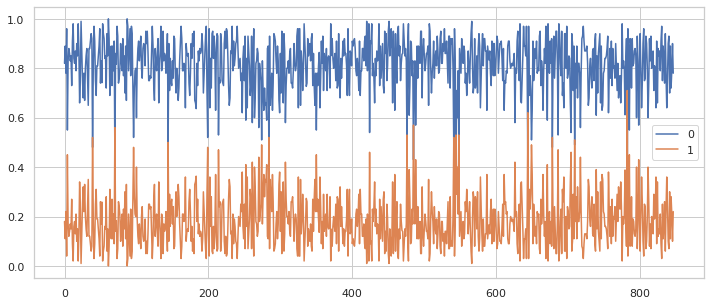

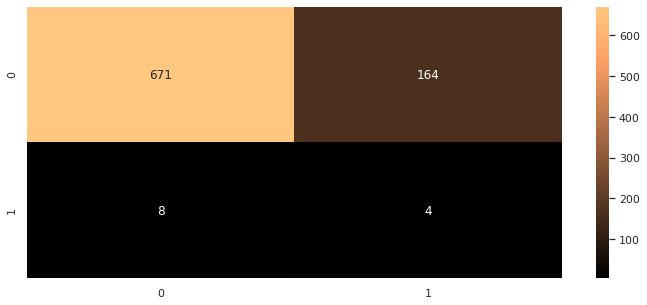

0.5060137457044673


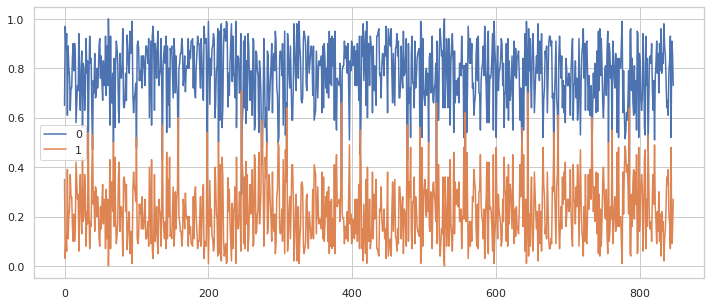

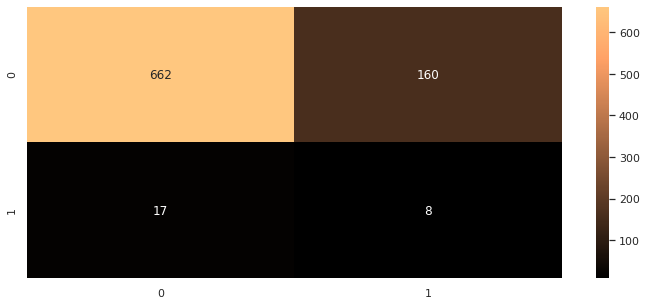

0.5112911143838978


In [92]:
# target encoding
def my_rf(Xtrain,ytrain,Xtest,ytest):
  rf = RandomForestClassifier()
  rf.fit(Xtrain, ytrain)
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
  max_depth=10, max_features='auto', max_leaf_nodes=None,
  min_impurity_split=1e-07, min_samples_leaf=1,
  min_samples_split=2, min_weight_fraction_leaf=0.0,
  n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
  verbose=0, warm_start=False)
  y_pred = rf.predict(Xtest)

  #Print model report:


  pd.DataFrame(rf.predict_proba(Xtest)).plot()
  plt.show()

  sns.heatmap(pd.DataFrame(confusion_matrix(y_pred,ytest)), annot=True, cmap='copper', fmt="d")
  plt.show()

  false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  print(roc_auc)

my_rf(Xtrain = X_train,
      ytrain = y1_train,
      Xtest = X_test,
      ytest = y1_test)


my_rf(Xtrain = X_train_oe,
      ytrain = y1_train_oe,
      Xtest = X_test_oe,
      ytest = y1_test_oe)

my_rf(Xtrain = X_train_le,
      ytrain = y1_train_le,
      Xtest = X_test_le,
      ytest = y1_test_le)